In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as math
# from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from datetime import date
from datetime import datetime


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import tree

from sklearn import ensemble

In [2]:
def agg_string_to_arr(arr):
    new_arr = []
    for e in arr:
        if e not in new_arr:
            new_arr.append(e)
    return new_arr

def attendance_demog_wash_by_year(attendance, demog):
    #CSV -> DF
    attendance_df = pd.read_csv(attendance)
    demog_df = pd.read_csv(demog)
    
    #ATTENDANCE
    #----------
    
    #Extrapolate attendance specifier as boolean columns
    one_hot_atten = pd.get_dummies(attendance_df['Attendance'])
    one_hot_sesh = pd.get_dummies(attendance_df['Session'])
    attendance_clean = attendance_df.join(one_hot_atten)
    attendance_clean = attendance_clean.join(one_hot_sesh)
    
    #Combine rows by ChildID and 
    attendance_clean = attendance_clean.groupby(['ChildID'],as_index=False).agg(
             {'Best Interest': 'sum',
              'In Attendance': 'sum',
              'Other': 'sum',
              'Sick':'sum',
              'Unexcused Absence':'sum',
              'FD':'sum',
              'PD':'sum',
              'Center':agg_string_to_arr})
    
    #Add aggregate columns: Total Attendance,Absence, and Days AND Attendance Rate
    attendance_clean['Total Attendance'] = attendance_clean['In Attendance']
    attendance_clean['Total Absence'] = attendance_clean['Other'] + attendance_clean['Sick'] + attendance_clean['Unexcused Absence'] + attendance_clean['Best Interest']
    attendance_clean['Total Days'] = attendance_clean['Total Attendance'] + attendance_clean['Total Absence']
    attendance_clean['Attendance Rate'] = attendance_clean['Total Attendance'] / attendance_clean['Total Days']
    
    attendance_clean_final = attendance_clean
    
    #DEMOGRAPHICS
    #------------
    
    #Reorder Columns
    demog_clean = demog_df[['ChildID','ChildEthnicity','ChildRace','ChildLanguage','ChildFlags','ChildDateofBirth']]
    
    #Drop NAN 
    demog_clean = demog_clean[demog_clean['ChildDateofBirth'].notna()]

    #Add current age column
    today = datetime.today() 

    def get_age(bday_str):
        datetime_bday = datetime.strptime(str(bday_str),"%m/%d/%Y")
        age = (today-datetime_bday).days // 365
        return age

    demog_clean['Age (as of current day)'] = demog_clean['ChildDateofBirth'].apply(get_age)
    demog_clean['ChildID'] = demog_clean.ChildID.astype(int)
    
    #Aggregate rows to combine duplicate ChildIDs
    
    #Df with only aggregated string columns
    combined_str = demog_clean.groupby('ChildID').agg({'ChildRace':agg_string_to_arr, 'ChildFlags':agg_string_to_arr})
    
    #Combine agg str with demog clean
    merged = combined_str.merge(demog_clean, on = 'ChildID',how = 'left')
    
    #Drop extraneous columns 
    cleaned = merged[['ChildID','ChildEthnicity','ChildLanguage','ChildRace_x','ChildFlags_x','ChildDateofBirth','Age (as of current day)']]
    
    #Drop duplicates rows
    demog_clean_final = cleaned.drop_duplicates(subset= 'ChildID')
    
    #Rename columns
    demog_clean_final = demog_clean_final.rename(columns = {"ChildRace_x":'ChildRace',"ChildFlags_x":'ChildFlags'})
    
    
    #JOIN DFs for MASTER
    master = pd.merge(demog_clean_final,attendance_clean_final, how='inner', on= 'ChildID')
    
    #EXPORT
    #------
    from pathlib import Path 

    filepath = Path(attendance + '_out.csv')  
    filepath.parent.mkdir(parents=True, exist_ok=True)  
    master.to_csv(filepath)
    
    return master

df = attendance_demog_wash_by_year('18-19 attendance master.csv','PvH-demographicsdash_childdata.csv')
df

,ChildID,ChildEthnicity,ChildLanguage,ChildRace,ChildFlags,ChildDateofBirth,Age (as of current day),Best Interest,In Attendance,Other,Sick,Unexcused Absence,FD,PD,Center,Total Attendance,Total Absence,Total Days,Attendance Rate
0,18578,Hispanic or Latino,01 -- Spanish,[Caucasian],[Preschool],12/28/2004,17,0,102.0,0,0,0,102.0,0,[FH],102.0,0,102.0,1.000000
1,22717,Hispanic or Latino,01 -- Spanish,[Caucasian],[Infant/Toddler],01/13/2008,14,0,245.0,2,1,0,248.0,0,[FH],245.0,3,248.0,0.987903
2,25173,Hispanic or Latino,00 -- English,[Caucasian],[Preschool],01/06/2007,15,0,242.0,2,4,0,248.0,0,[FH],242.0,6,248.0,0.975806
3,30829,Hispanic or Latino,01 -- Spanish,[Caucasian],[Infant/Toddler],11/19/2010,11,0,246.0,2,0,0,248.0,0,[FH],246.0,2,248.0,0.991935
4,31583,Hispanic or Latino,00 -- English,[Caucasian],[Emergency Care],05/22/2010,12,3,232.0,1,10,0,246.0,0,[Linda Vista],232.0,14,246.0,0.943089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4781,65271,Not Hispanic or Latino,00 -- English,[Caucasian],"[Admissions Agreement #15 (check box if Yes), ...",03/06/2015,7,0,2.0,0,0,0,0.0,2,[Emerald Vista],2.0,0,2.0,1.000000
4782,65289,Not Hispanic or Latino,00 -- English,[Caucasian],[nan],08/15/2016,6,0,1.0,0,0,0,1.0,0,[Esther Hobbs],1.0,0,1.0,1.000000
4783,65290,Hispanic or Latino,00 -- English,[nan],"[Shelter-In-Place, IFSP]",11/14/2017,4,0,3.0,0,0,0,3.0,0,[Esther Hobbs],3.0,0,3.0,1.000000
4784,65301,Hispanic or Latino,01 -- Spanish,[Caucasian],"[IEP, Admissions Agreement #16 (check box if Y...",05/12/2016,6,0,1.0,0,0,0,1.0,0,[Castlemont],1.0,0,1.0,1.000000


In [3]:
df.corr()

,ChildID,Age (as of current day),Best Interest,In Attendance,Other,Sick,Unexcused Absence,FD,PD,Total Attendance,Total Absence,Total Days,Attendance Rate
ChildID,1.000000,-0.565717,-0.044679,0.077854,0.012046,0.127882,0.026155,-0.064032,0.155320,0.077854,0.103509,0.094106,0.065740
Age (as of current day),-0.565717,1.000000,0.065824,-0.253582,-0.034234,-0.136858,0.020872,-0.235471,-0.011350,-0.253582,-0.105209,-0.251574,-0.179554
Best Interest,-0.044679,0.065824,1.000000,0.076753,0.059036,0.253617,0.367062,0.042274,0.138000,0.076753,0.489926,0.184656,-0.307991
In Attendance,0.077854,-0.253582,0.076753,1.000000,0.101039,0.386685,-0.116789,0.516286,0.437502,1.000000,0.342434,0.974919,0.569794
Other,0.012046,-0.034234,0.059036,0.101039,1.000000,0.074479,-0.007482,0.113333,0.059599,0.101039,0.364386,0.176624,-0.120190
Sick,0.127882,-0.136858,0.253617,0.386685,0.074479,1.000000,0.083485,0.073717,0.472932,0.386685,0.906363,0.560319,-0.028928
Unexcused Absence,0.026155,0.020872,0.367062,-0.116789,-0.007482,0.083485,1.000000,-0.050311,0.019240,-0.116789,0.307590,-0.031525,-0.326150
FD,-0.064032,-0.235471,0.042274,0.516286,0.113333,0.073717,-0.050311,1.000000,-0.521730,0.516286,0.093768,0.483670,0.303001
PD,0.155320,-0.011350,0.138000,0.437502,0.059599,0.472932,0.019240,-0.521730,1.000000,0.437502,0.436088,0.494341,0.154843
Total Attendance,0.077854,-0.253582,0.076753,1.000000,0.101039,0.386685,-0.116789,0.516286,0.437502,1.000000,0.342434,0.974919,0.569794


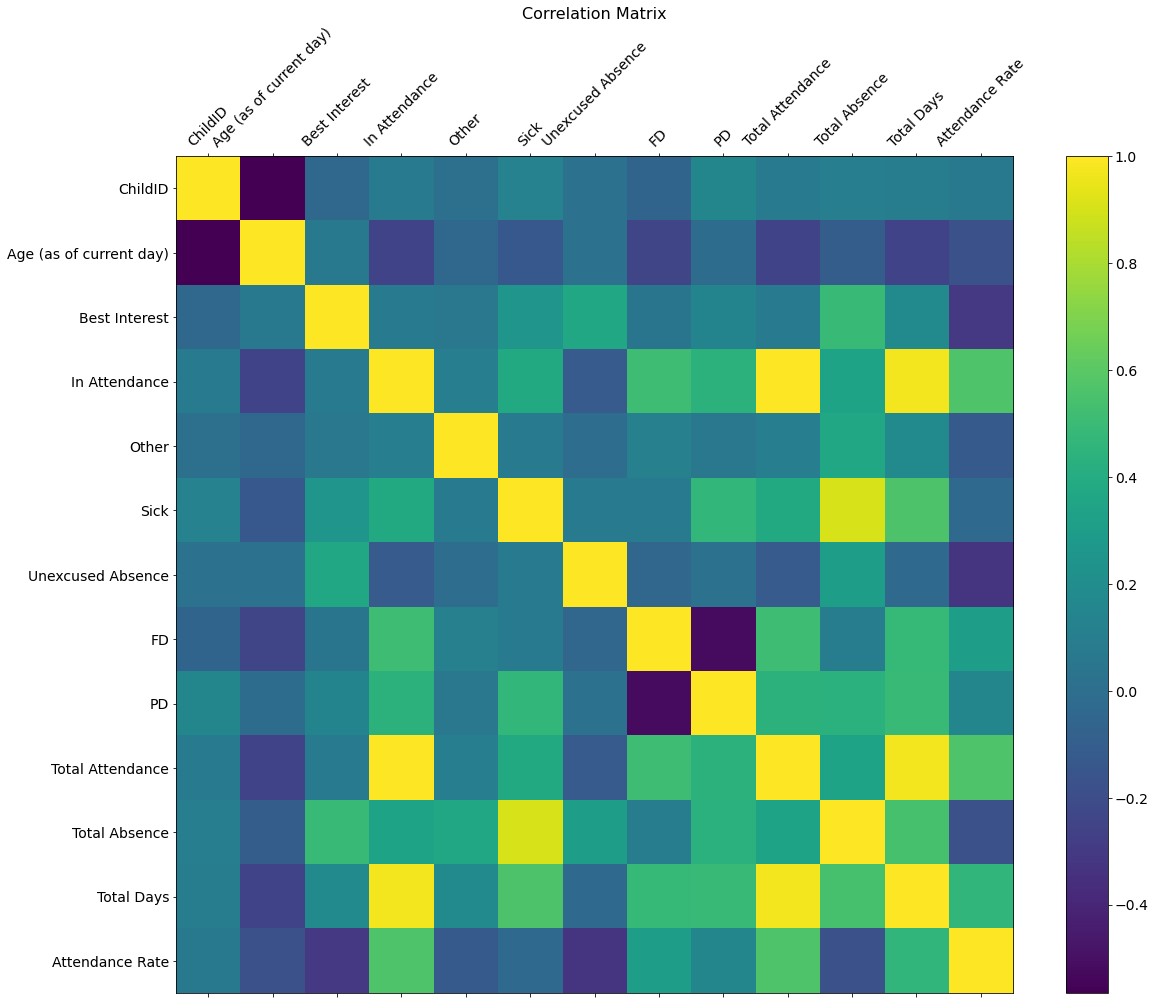

In [4]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [5]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,ChildID,Age (as of current day),Best Interest,In Attendance,Other,Sick,Unexcused Absence,FD,PD,Total Attendance,Total Absence,Total Days,Attendance Rate
ChildID,1.000000,-0.565717,-0.044679,0.077854,0.012046,0.127882,0.026155,-0.064032,0.155320,0.077854,0.103509,0.094106,0.065740
Age (as of current day),-0.565717,1.000000,0.065824,-0.253582,-0.034234,-0.136858,0.020872,-0.235471,-0.011350,-0.253582,-0.105209,-0.251574,-0.179554
Best Interest,-0.044679,0.065824,1.000000,0.076753,0.059036,0.253617,0.367062,0.042274,0.138000,0.076753,0.489926,0.184656,-0.307991
In Attendance,0.077854,-0.253582,0.076753,1.000000,0.101039,0.386685,-0.116789,0.516286,0.437502,1.000000,0.342434,0.974919,0.569794
Other,0.012046,-0.034234,0.059036,0.101039,1.000000,0.074479,-0.007482,0.113333,0.059599,0.101039,0.364386,0.176624,-0.120190
Sick,0.127882,-0.136858,0.253617,0.386685,0.074479,1.000000,0.083485,0.073717,0.472932,0.386685,0.906363,0.560319,-0.028928
Unexcused Absence,0.026155,0.020872,0.367062,-0.116789,-0.007482,0.083485,1.000000,-0.050311,0.019240,-0.116789,0.307590,-0.031525,-0.326150
FD,-0.064032,-0.235471,0.042274,0.516286,0.113333,0.073717,-0.050311,1.000000,-0.521730,0.516286,0.093768,0.483670,0.303001
PD,0.155320,-0.011350,0.138000,0.437502,0.059599,0.472932,0.019240,-0.521730,1.000000,0.437502,0.436088,0.494341,0.154843
Total Attendance,0.077854,-0.253582,0.076753,1.000000,0.101039,0.386685,-0.116789,0.516286,0.437502,1.000000,0.342434,0.974919,0.569794


In [6]:
np.mean(df['Attendance Rate'])

0.7430834435670661

In [7]:
df['ChildLanguage'].unique()

array(['01 -- Spanish', '00 -- English', '03 -- Cantonese',
       '07 -- Mandarin (Phutonghua)', '02 -- Vietnamese',
       '99 --  Other Non English', '11 -- Arabic', '13 -- Burmese',
       '19 -- Greek', '16 -- Farsi ( Persian )', '35 -- Urdu',
       '28 -- Punjabi', '27 -- Italian', '05 -- Phlipino (Tagalong)',
       '22 -- Hindi', '04 -- Korean', '42 -- Assyrian',
       '55 -- Other Languages of China', '40 -- Pashto', '25 -- Ilocano',
       '29 -- Russian', '17 -- French', '43 -- Gujarati',
       '09 -- Khmer ( Cambodian )', '44 -- Mien', '08 -- Japanese',
       '21 -- Hebrew', '06 -- Portuguese'], dtype=object)

In [49]:
def attendance_demog_wash_by_center(attendance, demog):
    #-explain
    
    #CSV -> DF
    attendance_df = pd.read_csv(attendance)
    demog_df = pd.read_csv(demog)
    
    #ATTENDANCE
    #----------
    
    #Extrapolate attendance specifier as boolean columns
    one_hot_atten = pd.get_dummies(attendance_df['Attendance'])
    one_hot_sesh = pd.get_dummies(attendance_df['Session'])
    attendance_clean = attendance_df.join(one_hot_atten)
    attendance_clean = attendance_clean.join(one_hot_sesh)
    
    #Combine rows by ChildID and 
    attendance_clean = attendance_clean.groupby(['ChildID','Center'],as_index=False).agg(
             {'Best Interest': 'sum',
              'In Attendance': 'sum',
              'Other': 'sum',
              'Sick':'sum',
              'Unexcused Absence':'sum',
              'FD':'sum',
              'PD':'sum'})
    
    #Add aggregate columns: Total Attendance,Absence, and Days AND Attendance Rate
    attendance_clean['Total Attendance'] = attendance_clean['In Attendance']
    attendance_clean['Total Absence'] = attendance_clean['Other'] + attendance_clean['Sick'] + attendance_clean['Unexcused Absence'] + attendance_clean['Best Interest']
    attendance_clean['Total Days'] = attendance_clean['Total Attendance'] + attendance_clean['Total Absence']
    attendance_clean['Attendance Rate'] = attendance_clean['Total Attendance'] / attendance_clean['Total Days']
    
    attendance_clean_final = attendance_clean
    
    #DEMOGRAPHICS
    #------------
    
    #Reorder Columns
    demog_clean = demog_df[['ChildID','ChildEthnicity','ChildRace','ChildLanguage','ChildFlags','ChildDateofBirth']]
    
    #Drop NAN 
    demog_clean = demog_clean[demog_clean['ChildDateofBirth'].notna()]

    #Add current age column
    today = datetime.today() 

    def get_age(bday_str):
        datetime_bday = datetime.strptime(str(bday_str),"%m/%d/%Y")
        age = (today-datetime_bday).days // 365
        return age

    demog_clean['Age (as of current day)'] = demog_clean['ChildDateofBirth'].apply(get_age)
    
    #Make ID# an int
    demog_clean['ChildID'] = demog_clean.ChildID.astype(int)
    
    #Aggregate rows to combine duplicate ChildIDs
    
    #Df with only aggregated string columns
    combined_str = demog_clean.groupby('ChildID').agg({'ChildRace':agg_string_to_arr, 'ChildFlags':agg_string_to_arr})
    
    #Combine agg str with demog clean
    merged = combined_str.merge(demog_clean, on = 'ChildID',how = 'left')
    
    #Drop extraneous columns 
    cleaned = merged[['ChildID','ChildEthnicity','ChildLanguage','ChildRace_x','ChildFlags_x','ChildDateofBirth','Age (as of current day)']]
    
    #Drop duplicates rows
    demog_clean_final = cleaned.drop_duplicates(subset= 'ChildID')
    
    #Rename columns
    demog_clean_final = demog_clean_final.rename(columns = {"ChildRace_x":'ChildRace',"ChildFlags_x":'ChildFlags'})
    
    
    #JOIN DFs for MASTER
    master = pd.merge(demog_clean_final,attendance_clean_final, how='inner', on= 'ChildID')
    
    #EXPORT
    #------
    from pathlib import Path 

    filepath = Path(attendance[:-4] + 'CENTER_out.csv')  
    filepath.parent.mkdir(parents=True, exist_ok=True)  
    master.to_csv(filepath)
    
    return master

df_center = attendance_demog_wash_by_center('18-19 attendance master.csv','PvH-demographicsdash_childdata.csv')
df_center

,ChildID,ChildEthnicity,ChildLanguage,ChildRace,ChildFlags,ChildDateofBirth,Age (as of current day),Center,Best Interest,In Attendance,Other,Sick,Unexcused Absence,FD,PD,Total Attendance,Total Absence,Total Days,Attendance Rate
0,18578,Hispanic or Latino,01 -- Spanish,[Caucasian],[Preschool],12/28/2004,17,FH,0,102.0,0,0,0,102.0,0,102.0,0,102.0,1.000000
1,22717,Hispanic or Latino,01 -- Spanish,[Caucasian],[Infant/Toddler],01/13/2008,14,FH,0,245.0,2,1,0,248.0,0,245.0,3,248.0,0.987903
2,25173,Hispanic or Latino,00 -- English,[Caucasian],[Preschool],01/06/2007,15,FH,0,242.0,2,4,0,248.0,0,242.0,6,248.0,0.975806
3,30829,Hispanic or Latino,01 -- Spanish,[Caucasian],[Infant/Toddler],11/19/2010,11,FH,0,246.0,2,0,0,248.0,0,246.0,2,248.0,0.991935
4,31583,Hispanic or Latino,00 -- English,[Caucasian],[Emergency Care],05/22/2010,12,Linda Vista,3,232.0,1,10,0,246.0,0,232.0,14,246.0,0.943089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4967,65271,Not Hispanic or Latino,00 -- English,[Caucasian],"[Admissions Agreement #15 (check box if Yes), ...",03/06/2015,7,Emerald Vista,0,2.0,0,0,0,0.0,2,2.0,0,2.0,1.000000
4968,65289,Not Hispanic or Latino,00 -- English,[Caucasian],[nan],08/15/2016,6,Esther Hobbs,0,1.0,0,0,0,1.0,0,1.0,0,1.0,1.000000
4969,65290,Hispanic or Latino,00 -- English,[nan],"[Shelter-In-Place, IFSP]",11/14/2017,4,Esther Hobbs,0,3.0,0,0,0,3.0,0,3.0,0,3.0,1.000000
4970,65301,Hispanic or Latino,01 -- Spanish,[Caucasian],"[IEP, Admissions Agreement #16 (check box if Y...",05/12/2016,6,Castlemont,0,1.0,0,0,0,1.0,0,1.0,0,1.0,1.000000


In [50]:
df_center.select_dtypes(exclude='number').columns

Index(['ChildEthnicity', 'ChildLanguage', 'ChildRace', 'ChildFlags',
       'ChildDateofBirth', 'Center'],
      dtype='object')

In [64]:
df_center_ohe = df_center
for col in ['ChildEthnicity', 'ChildLanguage']:
    ohe = pd.get_dummies(df_center[col])
    df_center_ohe = df_center_ohe.join(ohe)
#     df_center_ohe.drop(columns = [col])

In [24]:
decision_tree_model = tree.DecisionTreeClassifier(random_state = 42, criterion = 'entropy')

In [17]:
pd.get_dummies(df_center[''])


,Center,ChildDateofBirth,ChildEthnicity,ChildFlags,ChildLanguage,ChildRace
0,0,0,1,0,0,0
1,0,0,0,0,1,0
2,0,0,0,0,0,1
3,0,0,0,1,0,0
4,0,1,0,0,0,0
5,1,0,0,0,0,0


In [66]:
# df_center_ohe
df_center_ohe.drop(columns = ['ChildEthnicity'])
df_center_ohe.drop(columns = ['ChildLanguage'])

,ChildID,ChildEthnicity,ChildRace,ChildFlags,ChildDateofBirth,Age (as of current day),Center,Best Interest,In Attendance,Other,...,27 -- Italian,28 -- Punjabi,29 -- Russian,35 -- Urdu,40 -- Pashto,42 -- Assyrian,43 -- Gujarati,44 -- Mien,55 -- Other Languages of China,99 -- Other Non English
0,18578,Hispanic or Latino,[Caucasian],[Preschool],12/28/2004,17,FH,0,102.0,0,...,0,0,0,0,0,0,0,0,0,0
1,22717,Hispanic or Latino,[Caucasian],[Infant/Toddler],01/13/2008,14,FH,0,245.0,2,...,0,0,0,0,0,0,0,0,0,0
2,25173,Hispanic or Latino,[Caucasian],[Preschool],01/06/2007,15,FH,0,242.0,2,...,0,0,0,0,0,0,0,0,0,0
3,30829,Hispanic or Latino,[Caucasian],[Infant/Toddler],11/19/2010,11,FH,0,246.0,2,...,0,0,0,0,0,0,0,0,0,0
4,31583,Hispanic or Latino,[Caucasian],[Emergency Care],05/22/2010,12,Linda Vista,3,232.0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4967,65271,Not Hispanic or Latino,[Caucasian],"[Admissions Agreement #15 (check box if Yes), ...",03/06/2015,7,Emerald Vista,0,2.0,0,...,0,0,0,0,0,0,0,0,0,0
4968,65289,Not Hispanic or Latino,[Caucasian],[nan],08/15/2016,6,Esther Hobbs,0,1.0,0,...,0,0,0,0,0,0,0,0,0,0
4969,65290,Hispanic or Latino,[nan],"[Shelter-In-Place, IFSP]",11/14/2017,4,Esther Hobbs,0,3.0,0,...,0,0,0,0,0,0,0,0,0,0
4970,65301,Hispanic or Latino,[Caucasian],"[IEP, Admissions Agreement #16 (check box if Y...",05/12/2016,6,Castlemont,0,1.0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:

df_center_train, df_center_test = train_test_split(df_center_ohe, test_size = 0.25, random_state = 42)

In [69]:
df_center_test

,ChildID,ChildEthnicity,ChildLanguage,ChildRace,ChildFlags,ChildDateofBirth,Age (as of current day),Center,Best Interest,In Attendance,...,27 -- Italian,28 -- Punjabi,29 -- Russian,35 -- Urdu,40 -- Pashto,42 -- Assyrian,43 -- Gujarati,44 -- Mien,55 -- Other Languages of China,99 -- Other Non English
1905,57756,Hispanic or Latino,00 -- English,[Caucasian],[nan],06/06/2014,8,Amador,2,223.0,...,0,0,0,0,0,0,0,0,0,0
4011,61662,Not Hispanic or Latino,00 -- English,[Asian],[Admissions Agreement #14 (check box if Yes)],09/26/2014,8,Meadowfair,4,83.0,...,0,0,0,0,0,0,0,0,0,0
4162,61913,Hispanic or Latino,00 -- English,[Asian],[Shelter-In-Place],11/24/2014,7,Dorsa,1,183.0,...,0,0,0,0,0,0,0,0,0,0
2297,58657,Hispanic or Latino,00 -- English,[Caucasian],[nan],08/18/2013,9,Cesar Chavez,5,13.0,...,0,0,0,0,0,0,0,0,0,0
4083,61784,Hispanic or Latino,00 -- English,[Caucasian],[Admissions Agreement #14 (check box if Yes)],04/23/2015,7,Baldwin Park,0,91.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1477,56717,Hispanic or Latino,00 -- English,[Caucasian],[nan],08/26/2014,8,Del Rey,3,7.0,...,0,0,0,0,0,0,0,0,0,0
3128,60183,Hispanic or Latino,00 -- English,[Caucasian],[nan],09/12/2014,8,Linda Vista,0,223.0,...,0,0,0,0,0,0,0,0,0,0
4618,62704,Hispanic or Latino,00 -- English,[Caucasian],"[Inactive: Head Start Santa Clara County, Adm...",05/04/2017,5,Eden Palms,3,99.0,...,0,0,0,0,0,0,0,0,0,0
2883,59778,Hispanic or Latino,01 -- Spanish,[Caucasian],[nan],07/26/2014,8,Cesar Chavez,10,172.0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
lr = LogisticRegression()
lr.fit(df_center_train[['Age (as of current day)', 'Hispanic or Latino', 'Not Hispanic or Latino']], df_center_train['Attendance Rate'])

ValueError: Unknown label type: 'continuous'